# Your First Image Classifier: Using CNN to Classify Images
# Train

The purpose of this dataset is to correctly classify an image as containing a dog, cat, or panda.
Containing only 3,000 images, the Animals dataset is meant to be another **introductory** dataset
that we can quickly train a CNN model and obtain a comparative results with the previous KNN model.


Let's take the following steps:

1. Encoding target variable
2. Training the CNN model
3. Export the model and the encoder object

<center><img width="800" src="https://drive.google.com/uc?export=view&id=1fKGuR5U5ECf7On6Zo1UWzAIWZrMmZnGc"></center>


## Step 01: Setup

Start out by installing the experiment tracking library and setting up your free W&B account:


*   **pip install wandb** – Install the W&B library
*   **import wandb** – Import the wandb library
*   **wandb login** – Login to your W&B account so you can log all your metrics in one place

In [1]:
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 28.4 MB/s 
     |████████████████████████████████| 162 kB 65.9 MB/s 
     |████████████████████████████████| 182 kB 68.4 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 162 kB 61.5 MB/s 
     |████████████████████████████████| 158 kB 74.0 MB/s 
     |████████████████████████████████| 157 kB 74.3 MB/s 
     |████████████████████████████████| 157 kB 72.8 MB/s 
     |████████████████████████████████| 157 kB 74.2 MB/s 
     |████████████████████████████████| 157 kB 75.8 MB/s 
     |████████████████████████████████| 157 kB 69.1 MB/s 
     |████████████████████████████████| 157 kB 71.6 MB/s 
     |████████████████████████████████| 157 kB 56.2 MB/s 
     |████████████████████████████████| 156 kB 51.1 MB/s 


In [2]:
# a Python package for tracking the carbon emissions produced by various
# kinds of computer programs, from straightforward algorithms to deep neural networks.
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 24.2 MB/s 
     |████████████████████████████████| 99 kB 9.9 MB/s 
     |████████████████████████████████| 66 kB 5.4 MB/s 
     |████████████████████████████████| 46 kB 5.2 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=e89bae36714781ba1d3dccb0d55b52d76ee827b6c4df7349b032c46e09599b73
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
Successfully built py-cpuinfo


### Import Packages

In [3]:
import logging
import joblib
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np
from codecarbon import EmissionsTracker
from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback
import os
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import wandb

In [4]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

## Step 02 Basic configuration and download artifacts

In [6]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "cnn_classifier",
  "train_feature_artifact": "train_x:latest",
  "train_target_artifact": "train_y:latest",
  "val_feature_artifact": "val_x:latest",
  "val_target_artifact": "val_y:latest",
  "encoder": "target_encoder",
  "inference_model": "model.h5"
}

In [7]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="morsinaldo",project=args["project_name"], job_type="Train")

logger.info("Downloading the train and validation data")
# train x
train_x_artifact = run.use_artifact(args["train_feature_artifact"])
train_x_path = train_x_artifact.file()

# train y
train_y_artifact = run.use_artifact(args["train_target_artifact"])
train_y_path = train_y_artifact.file()

# validation x
val_x_artifact = run.use_artifact(args["val_feature_artifact"])
val_x_path = val_x_artifact.file()

# validation y
val_y_artifact = run.use_artifact(args["val_target_artifact"])
val_y_path = val_y_artifact.file()

# unpacking the artifacts
train_x = joblib.load(train_x_path)
train_y = joblib.load(train_y_path)
val_x = joblib.load(val_x_path)
val_y = joblib.load(val_y_path)

wandb: Currently logged in as: morsinaldo. Use `wandb login --relogin` to force relogin


15-10-2022 11:00:57 Downloading the train and validation data


In [8]:
logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Validation x: {}".format(val_x.shape))
logger.info("Validation y: {}".format(val_y.shape))

15-10-2022 11:01:00 Train x: (1687, 32, 32, 3)
15-10-2022 11:01:00 Train y: (1687,)
15-10-2022 11:01:00 Validation x: (563, 32, 32, 3)
15-10-2022 11:01:00 Validation y: (563,)


## Step 03: Encoder the target variable

In [9]:
# encode the labels as Binarizers
lb = LabelBinarizer()

# take care not to produce data lakeage
train_y = lb.fit_transform(train_y)
val_y = lb.transform(val_y)

In [10]:
lb.classes_

array(['cats', 'dogs', 'panda'], dtype='<U5')

In [11]:
train_y[4]

array([1, 0, 0])

In [12]:
val_y[3]

array([0, 1, 0])

## Step 04: Model definition

Source code based on **Rosebrock, Adrian. Deep Learning For Computer vision with Python, 2019** [link](https://pyimagesearch.com/deep-learning-computer-vision-python-book/)

In [13]:
class ShallowNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last"
		model = Sequential()
		inputShape = (height, width, depth)

		# if we are using "channels first", update the input shape
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)

		# define the first (and only) CONV => RELU layer
		model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
		model.add(Activation("relu"))

		# softmax classifier
		model.add(Flatten())
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

In [14]:
# create a model object
model = ShallowNet.build(32,32,3,3)

# summarize layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 3)                 98307     
                                                                 
 activation_1 (Activation)   (None, 3)                 0         
                                                                 
Total params: 99,203
Trainable params: 99,203
Non-trainable params: 0
_________________________________________________________________


## Step 05: Training

In [15]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(learning_rate=0.005)
model = ShallowNet.build(width=32, height=32, depth=3, classes=3)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

# train the network
print("[INFO] training network...")
history = model.fit(train_x, train_y, 
              validation_data=(val_x, val_y),
              batch_size=32, 
              epochs=100, 
              verbose=0,
              callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                   compute_flops=True)]
          )

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

[INFO] compiling model...
[INFO] training network...


15-10-2022 11:01:05 From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_ops.py:5219: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


## Step 06: Evaluation Metrics

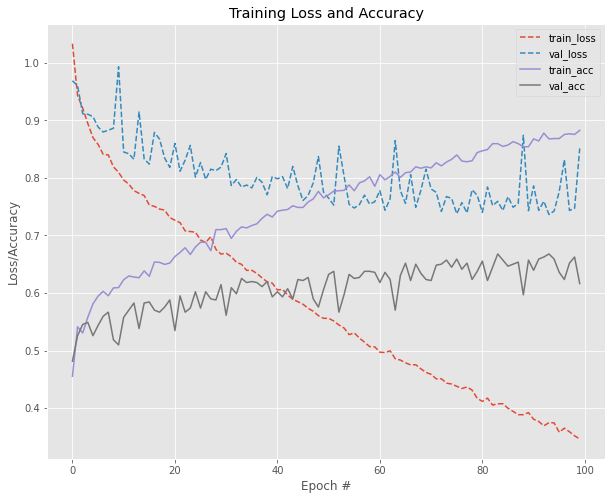

In [16]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 100), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 100), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 100), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 100), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [17]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.0008730002972411044 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 5.505760584310612e-05 kWh
[INFO] Energy consumed for all GPU: 0.00032555145543714366 kWh
[INFO] Energy consumed for all CPU: 0.0004923912359608545 kWh
[INFO] CO2 emission 0.0001907806429264942(in Kg)


In [18]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(val_x, batch_size=32)
print(classification_report(val_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=lb.classes_))

[INFO] evaluating network...
18/18 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

        cats       0.65      0.27      0.38       198
        dogs       0.44      0.73      0.55       159
       panda       0.82      0.86      0.84       206

    accuracy                           0.62       563
   macro avg       0.64      0.62      0.59       563
weighted avg       0.65      0.62      0.60       563



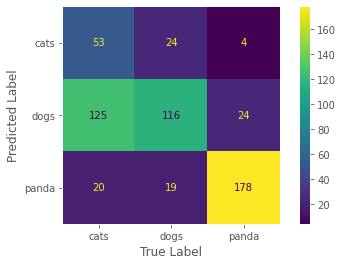

In [19]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predictions.argmax(axis=1),
                                        val_y.argmax(axis=1)),
                       display_labels=lb.classes_).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [20]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

15-10-2022 11:01:47 Uploading figures


In [21]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(val_y.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(val_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(val_y.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(val_y.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

15-10-2022 11:01:47 Validation Evaluation metrics
15-10-2022 11:01:47 Validation Accuracy: 0.6163410301953819
15-10-2022 11:01:47 Validation Precision: 0.6538765791845491
15-10-2022 11:01:47 Validation Recall: 0.6163410301953819
15-10-2022 11:01:47 Validation F1: 0.596086971303815


In [22]:
logger.info("Dumping the model and encoder artifacts to the disk")

# Save the artifacts using joblib
joblib.dump(lb, args["encoder"])
model.save(os.path.join(wandb.run.dir, args["inference_model"]))

15-10-2022 11:01:47 Dumping the model and encoder artifacts to the disk


In [23]:
# encoder artifact
artifact = wandb.Artifact(args["encoder"],
                          type="INFERENCE_MODEL",
                          description="A json file representing the target encoder"
                          )

logger.info("Logging the target encoder artifact")
artifact.add_file(args["encoder"])
run.log_artifact(artifact)

15-10-2022 11:01:47 Logging the target encoder artifact


In [24]:
# inference model artifact
artifact = wandb.Artifact(args["inference_model"],
                          type="INFERENCE_MODEL",
                          description="A json file representing the inference model"
                          )

logger.info("Logging the inference model artifact")
artifact.add_file(os.path.join(wandb.run.dir, args["inference_model"]))
run.log_artifact(artifact)

15-10-2022 11:01:47 Logging the inference model artifact


In [25]:
run.finish()

accuracy,▁▂▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▃▄▄▅▅▄▃▄▄▅▄▆▆▆▆▅▆▅▇▅▆▇▆▄▆▇▇█▇▆▆█▇▅██▆▆
val_loss,█▆▆▅▄▄▄▅▅▄▄▃▄▂▂▂▃▄▂▄▂▃▁▂▂▅▃▂▂▂▂▂▂▂▁▅▁▁▄▄
Acc,0.61634
CO2_Emissions,0.00019
Count_Params,99203
Energy_CPU,0.00049
Energy_Consumed,0.00087
Energy_GPU,0.00033


**How can we improve this model?**

-  Data Augmentation [Link](https://colab.research.google.com/drive/1S8SJvH4bqhPvurG4gjh3-t-XulX4S8JX#scrollTo=me4Jr5IhaT0j)
- Batch Normalization
- Dropout
- Add more CNN layers
- Add more hidden layers in the head

## Step 07: Sweep (hyperparameter tuning)

### Sweep setup

ℹ️ [Reference](https://docs.wandb.ai/guides/sweeps/define-sweep-configuration)

**Sweep configuration structure**

Sweep configurations are nested; keys can have, as their values, further keys. The top-level keys are listed and briefly described below, and then detailed in the following section.

| Top-Level Key | Description                                         |
|---------------|-----------------------------------------------------|
| **program**       | (required) Training script to run.                  |
| **method**        | (required) Specify the <br>search strategy.         |
| **parameters**    | (required) Specify <br>parameters bounds to search. |

<br>

**Search type methods**

The following list describes hyperparameter search methods. Specify the search strategy with the **method**:

- **grid**  – Iterate over every combination of hyperparameter values. Can be computationally costly.
- **random**  – Choose a random set of hyperparameter values on each iteration based on provided distributions.
- **bayes** – Create a probabilistic model of a metric score as a function of the hyperparameters, and choose parameters with high probability of improving the metric. 
<br>

**Metric**

Describes the metric to optimize. This metric should be logged **explicitly** to W&B by your training script.

| Key    | Description |
|--------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **name**   | Name of the metric to optimize.|
| **goal**   | Either minimize or  maximize (Default is <br>minimize.|
| **target** | Goal value for the metric you're optimizing. <br>When any run in the sweep achieves that target value,<br> the sweep's state will be set to finished. <br>This means all agents with active runs will <br>finish those jobs, but no new runs will <br>be launched in the sweep. |

In [26]:
# Configure the sweep 
sweep_config = {
    "name": "my-cnn-sweep",
    'method': 'random', 
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'conv_layer': {
            'max': 3,
            'min': 1,
            'distribution': 'int_uniform',
        },
        'hidden_layer': {
            'values': [0,1,2,3]
        },
        'learn_rate': {
            'values': [0.01,0.001,0.005],  
        },
        'epoch': {
            'values': [100,200]
        },
        'batch_size': {
            'values': [32,64]
        }
    }
}

⚠️⚠️⚠️

> Please, you must run again the **Steps 02** (basic configuration and download artifacts) and **03** (encoder the target variable). 

In [27]:
# Initialize a new sweep
# Arguments:
#     – sweep_config: the sweep config dictionary defined above
#     – entity: Set the username for the sweep
#     – project: Set the project name for the sweep
sweep_id = wandb.sweep(sweep_config,
                       entity="morsinaldo",
                       project=args["project_name"])

Create sweep with ID: crjmsr7f
Sweep URL: https://wandb.ai/morsinaldo/cnn_classifier/sweeps/crjmsr7f


### Adapt the model

In [28]:
class ShallowNetAdapt:
  @staticmethod
  def build(width, height, depth, classes, config):
    '''
      width, height, depth: dimensions of the image
      classes: number of targets
      config: variable used to configure the sweep
    '''
    # initialize the model along with the input shape to be
    # "channels last"
    model = Sequential()
    inputShape = (height, width, depth)

    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)

    for i in range(config.conv_layer):
      # define a convolution layer followed by a relu activation 
      # CONV => RELU layer
      model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
      model.add(Activation("relu"))

    # add a flatten layer
    model.add(Flatten())

    # add hidden layers followed by a relu activation
    for j in range(config.hidden_layer):
      model.add(Dense(10,activation="relu"))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    # return the constructed network architecture
    return model

### Training

In [29]:
def train():
    with wandb.init() as run:

      # create codecarbon tracker
      # codecarbon is too much verbose, change the log level for more info
      tracker = EmissionsTracker(log_level="critical")
      tracker.start()

      # initialize the optimizer and model
      print("[INFO] compiling model...")
      opt = SGD(learning_rate=run.config.learn_rate)
      model = ShallowNetAdapt.build(width=32, 
                               height=32,
                               depth=3, 
                               classes=3,
                               config=run.config)
      model.compile(loss="categorical_crossentropy", 
                    optimizer=opt,metrics=["accuracy"])

      # train the network
      print("[INFO] training network...")
      history = model.fit(train_x, train_y, 
                    validation_data=(val_x, val_y),
                    batch_size=run.config.batch_size, 
                    epochs=run.config.epoch, 
                    verbose=0,
                    callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                        compute_flops=True)]
                )

      # get co2 emissions from tracker
      # "CO2 emission (in Kg)"
      emissions = tracker.stop()

      # make predictions
      predictions = model.predict(val_x, batch_size=run.config.batch_size)

      # Evaluation Metrics
      logger.info("Validation Evaluation metrics")
      fbeta = fbeta_score(val_y.argmax(axis=1), 
                          predictions.argmax(axis=1), 
                          beta=1, zero_division=1,average='weighted')
      precision = precision_score(val_y.argmax(axis=1),
                                  predictions.argmax(axis=1),
                                  zero_division=1,average='weighted')
      recall = recall_score(val_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
      acc = accuracy_score(val_y.argmax(axis=1),
                          predictions.argmax(axis=1))

      logger.info("Validation Accuracy: {}".format(acc))
      logger.info("Validation Precision: {}".format(precision))
      logger.info("Validation Recall: {}".format(recall))
      logger.info("Validation F1: {}".format(fbeta))

      run.summary["Acc"] = acc
      run.summary["Precision"] = precision
      run.summary["Recall"] = recall
      run.summary["F1"] = fbeta
      # number of parameters
      run.summary["Count_Params"] = model.count_params()
      # energy unit is kWh
      run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
      run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
      run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
      run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
      # kg
      run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions


In [30]:
# Initialize a new sweep
# Arguments:
#     – sweep_id: the sweep_id to run - this was returned above by wandb.sweep()
#     – function: function that defines your model architecture and trains it
wandb.agent(sweep_id = sweep_id, function=train,count=5)

wandb: Agent Starting Run: enu6z5ho with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 2
wandb: 	epoch: 100
wandb: 	hidden_layer: 0
wandb: 	learn_rate: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
9/9 [==============================] - 0s 3ms/step


15-10-2022 11:02:23 Validation Evaluation metrics
15-10-2022 11:02:23 Validation Accuracy: 0.6234458259325044
15-10-2022 11:02:23 Validation Precision: 0.6333276507799511
15-10-2022 11:02:23 Validation Recall: 0.6234458259325044
15-10-2022 11:02:23 Validation F1: 0.6002323259730531


accuracy,▁▃▄▄▄▅▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇█████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▅▄▆▅▆▄▆▆▆▆▅▆▄▅▇▆▄▆▇▆▇▆▅▇▇▅▇▇▇▇▆█▇██▆▇▇▇
val_loss,▇▅▅▄▇▃█▄▃▃▃▄▂▄▃▂▃▅▃▃▄▂▃▄▂▂▅▂▂▂▂▃▁▁▁▁▄▁▂▂
Acc,0.62345
CO2_Emissions,0.0001
Count_Params,108451
Energy_CPU,0.00025
Energy_Consumed,0.00047
Energy_GPU,0.00019


wandb: Agent Starting Run: l176bj80 with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 1
wandb: 	epoch: 100
wandb: 	hidden_layer: 1
wandb: 	learn_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
9/9 [==============================] - 0s 3ms/step


15-10-2022 11:02:52 Validation Evaluation metrics
15-10-2022 11:02:52 Validation Accuracy: 0.6145648312611013
15-10-2022 11:02:52 Validation Precision: 0.6383262690316146
15-10-2022 11:02:52 Validation Recall: 0.6145648312611013
15-10-2022 11:02:52 Validation F1: 0.6236700003587667


accuracy,▁▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇███████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▆▆▆▆▅▅▅▅▅▅▄▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁
val_accuracy,▂▃▃▄▃▄▅▄▃▅▅▄▁▇▅▅▆▃▃▅▃▆▅▆▆▇▄█▄█▃▆▅▆▇▇▄█▇▇
val_loss,▅▄▄▄▃▃▄▂▅▂▂▃▆▂▄▃▁▅▅▂▄▃▄▃▂▁▄▂█▁▇▄▄▂▁▃█▂▃▂
Acc,0.61456
CO2_Emissions,7e-05
Count_Params,328619
Energy_CPU,0.00017
Energy_Consumed,0.00031
Energy_GPU,0.00012


wandb: Agent Starting Run: qa68soi2 with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 1
wandb: 	epoch: 200
wandb: 	hidden_layer: 0
wandb: 	learn_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
9/9 [==============================] - 0s 2ms/step


15-10-2022 11:03:45 Validation Evaluation metrics
15-10-2022 11:03:45 Validation Accuracy: 0.655417406749556
15-10-2022 11:03:45 Validation Precision: 0.6555821241217822
15-10-2022 11:03:45 Validation Recall: 0.655417406749556
15-10-2022 11:03:45 Validation F1: 0.6518110083243038


accuracy,▁▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
val_accuracy,▁▅▅▅▆▅▇▅▇▇▅▇▆▇▆▇▇█▇██▇▇█▇█▇█▇██▇▇▇▇█▇███
val_loss,█▄▃▅▂▄▂▃▂▂▇▂▃▂▃▁▂▁▁▂▁▂▂▂▄▂▃▂▄▃▃▄▄▅▄▄▅▄▄▅
Acc,0.65542
CO2_Emissions,0.0002
Count_Params,99203
Energy_CPU,0.00049
Energy_Consumed,0.0009
Energy_GPU,0.00036


wandb: Agent Starting Run: wxmkj6lf with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 2
wandb: 	epoch: 200
wandb: 	hidden_layer: 1
wandb: 	learn_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
9/9 [==============================] - 0s 3ms/step


15-10-2022 11:04:32 Validation Evaluation metrics
15-10-2022 11:04:32 Validation Accuracy: 0.6145648312611013
15-10-2022 11:04:32 Validation Precision: 0.6193171718748983
15-10-2022 11:04:32 Validation Recall: 0.6145648312611013
15-10-2022 11:04:32 Validation F1: 0.6157129242099647


accuracy,▁▂▂▂▃▄▄▅▄▅▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇█▇█▇█▇███▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▂▂▂▂▄▄▃▄▄▄▄▅▅▅▆▆▇▆▆▅▅▇▅▇▆▃▆▇▅▆█▇▆▅▆▆█
val_loss,█▇▆▅▄▄▄▄▃▄▃▃▃▃▃▃▃▂▃▂▂▃▃▃▂▂▂▂▄▂▂▃▂▁▁▂▃▂▃▁
Acc,0.61456
CO2_Emissions,0.00021
Count_Params,337867
Energy_CPU,0.00039
Energy_Consumed,0.00097
Energy_GPU,0.00053


wandb: Agent Starting Run: sq9lijsw with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 3
wandb: 	epoch: 100
wandb: 	hidden_layer: 1
wandb: 	learn_rate: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
9/9 [==============================] - 0s 3ms/step


15-10-2022 11:05:06 Validation Evaluation metrics
15-10-2022 11:05:06 Validation Accuracy: 0.6287744227353463
15-10-2022 11:05:06 Validation Precision: 0.6556593706916227
15-10-2022 11:05:06 Validation Recall: 0.6287744227353463
15-10-2022 11:05:06 Validation F1: 0.6333013278920063


accuracy,▁▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▄▃▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▅▅▄▃▄▅▅▄▅▅▅▅▅▅▅▆▆▅▇▇▇▆▇▇▄▇▆▆▇█▇▇▇▇██▇▇█
val_loss,▅▄▃▃▄▃▂▃▄▂▂▂▂▂▃▂▂▂▃▂▂▁▂▁▂█▁▃▂▁▂▂▂▂▂▁▂▃▃▂
Acc,0.62877
CO2_Emissions,0.00013
Count_Params,347115
Energy_CPU,0.00025
Energy_Consumed,0.00057
Energy_GPU,0.0003


In [31]:
run.finish()